# TODO:
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy - ADAM -TODO
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias) - TODO (zmienaimy seed i patrzymy czy tunowalność się zmienia -> tabelka z 10 seedami i patrzyma jak zmienia się tunowalnosć) -TODO ( przy pisaniu raportu)

### Imports

In [1]:
import itertools
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Real

from utills.best_config_bayes import (
    find_best_config_using_bayes,
    find_best_configs_in_search_space_with_bayes,
)
from utills.best_config_random_search import (
    find_best_configs_in_search_space_with_random_search,
)
from utills.dataset import load_dataset_from_id, split_dataset
from utills.dump_data import (
    dump_optimal_config_search_history,
    dump_scores_to_csv,
    dump_tunability_to_csv,
)
from utills.optimal_config import find_optimal_configuration_for_all_datasets
from utills.pipeline import get_column_transformer
from utills.tunability import (
    calculate_aggregate_tunability,
    calculate_tunability_on_each_dataset,
)

# Constants

In [27]:
NUM_ITER_BAYES = 50
NUM_POINTS_RS_DECISION_TREE = 50
NUM_POINTS_RS_ELASTIC_NET = 50
NUM_POINTS_RS_RANDOM_FOREST = 50
SEED=42

### Utill functions

### Load datasets

In [3]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
cars_dataset_id = (
    44994  # https://www.openml.org/search?type=data&status=active&id=44994
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)

rmftsa_ladata_dataset_id = (
    666  # https://www.openml.org/search?type=data&status=active&id=666
)
boston_dataset_id = 531  # https://www.openml.org/search?type=data&status=active&id=531

treasury_dataset_id = (
    42367  # https://www.openml.org/search?type=data&status=active&id=42367
)

bank32nh_dataset_id = (
    558  # https://www.openml.org/search?type=data&status=active&id=558
)

puma32H_dataset_id = 308  # https://www.openml.org/search?type=data&status=active&id=308

fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

cars_dataset: DataFrame = load_dataset_from_id(id=cars_dataset_id)
cars_regression_class = "Price"

diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

rmftsa_ladata_dataset = load_dataset_from_id(id=rmftsa_ladata_dataset_id)
rmftsa_ladata_regression_class = "Respiratory_Mortality"

boston_dataset = load_dataset_from_id(id=boston_dataset_id)
boston_regression_class = "MEDV"

treasury_dataset = load_dataset_from_id(id=treasury_dataset_id)
treasury_regression_class = "1MonthCDRate"

bank32nh_dataset = load_dataset_from_id(id=bank32nh_dataset_id)
bank32nh_regression_class = "rej"

puma32H_dataset = load_dataset_from_id(id=puma32H_dataset_id)
puma32H_regression_class = "thetadd6"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [4]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_cars,
    X_test_cars,
    y_train_cars,
    y_test_cars,
) = split_dataset(data=cars_dataset, class_=cars_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

(
    X_train_rmftsa_ladata,
    X_test_rmftsa_ladata,
    y_train_rmftsa_ladata,
    y_test_rmftsa_ladata,
) = split_dataset(rmftsa_ladata_dataset, rmftsa_ladata_regression_class)

X_train_boston, X_test_boston, y_train_boston, y_test_boston = split_dataset(
    boston_dataset, boston_regression_class
)

X_train_treasury, X_test_treasury, y_train_treasury, y_test_treasury = split_dataset(
    treasury_dataset, treasury_regression_class
)

X_train_bank32nh, X_test_bank32nh, y_train_bank32nh, y_test_bank32nh = split_dataset(
    bank32nh_dataset, bank32nh_regression_class
)

X_train_puma32H, X_test_puma32H, y_train_puma32H, y_test_puma32H = split_dataset(
    puma32H_dataset, puma32H_regression_class
)

In [5]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_cars, y_train_cars),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
        (X_train_rmftsa_ladata, y_train_rmftsa_ladata),
        (X_train_boston, y_train_boston),
        (X_train_treasury, y_train_treasury),
    ]

In [6]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_cars, y_test_cars),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
        (X_test_rmftsa_ladata, y_test_rmftsa_ladata),
        (X_test_boston, y_test_boston),
        (X_test_treasury, y_test_treasury),
    ]


# 1. Decision Tree

## Prepare model and search space

In [7]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [8]:
def get_parameter_grid_decision_tree():
    # parameters space
    random.seed(SEED)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_DECISION_TREE
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

## Find optimal default hyperparameters 

In [9]:
# find teta*

(
    optimal_config_decision_tree,
    best_summary_score_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_decision_tree_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/decision_tree/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


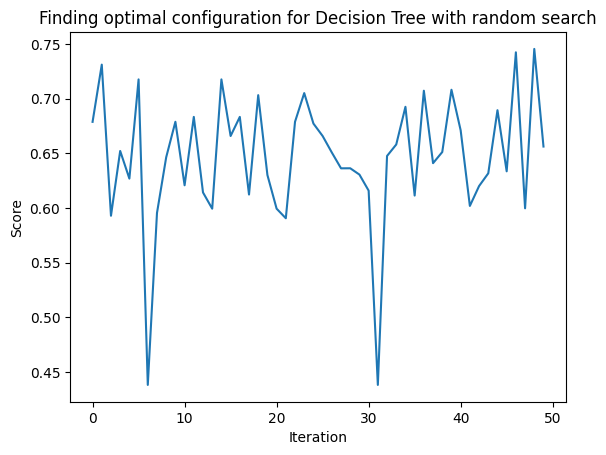

In [10]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Decision Tree with random search")
plt.show()

In [11]:
print(optimal_config_decision_tree)
print(best_summary_score_decision_tree)

{'model__ccp_alpha': 0.1, 'model__max_depth': 12, 'model__min_samples_split': 14, 'model__min_samples_leaf': 8}
0.7454811826282407


## Evaluate model with optimal hyperparameters on each dataset

In [12]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_decision_tree_pipeline()
    optimal_model.set_params(**optimal_config_decision_tree)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal decision tree score on dataset : " + str(score))

Optimal decision tree score on dataset : 0.9478807259710302
Optimal decision tree score on dataset : 0.9174357320922341
Optimal decision tree score on dataset : 0.400151089823659
Optimal decision tree score on dataset : 0.6461892689565107
Optimal decision tree score on dataset : 0.5670364411402389
Optimal decision tree score on dataset : 0.7828927482888243
Optimal decision tree score on dataset : 0.957320355809292


## Find best hyperparameters for given dataset with random search

In [13]:
# find tate^(j)*
(
    best_decision_tree_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/decision_tree/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9643548213621457
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
dataset: 1
score: 0.917435732092234
best config: {'model__ccp_alpha': 0.1, 'model__max_depth': 12, 'model__min_samples_split': 14, 'model__min_samples_leaf': 8}
dataset: 2
score: 0.46184442507636947
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 18, 'model__min_samples_split': 51, 'model__min_samples_leaf': 6}
dataset: 3
score: 0.698117764128138
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
dataset: 4
score: 0.5694226766895742
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
dataset: 5
score: 0.8431601442240128
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'mo

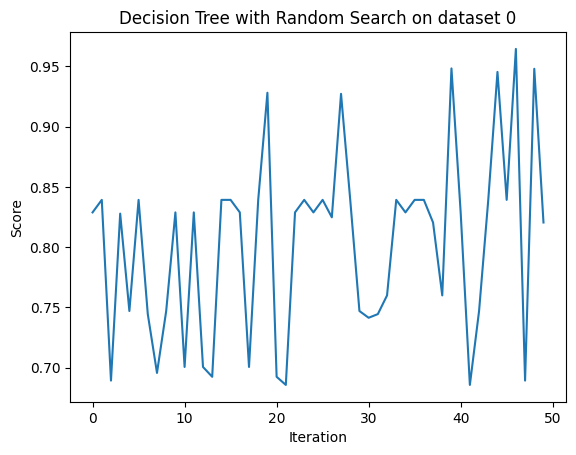

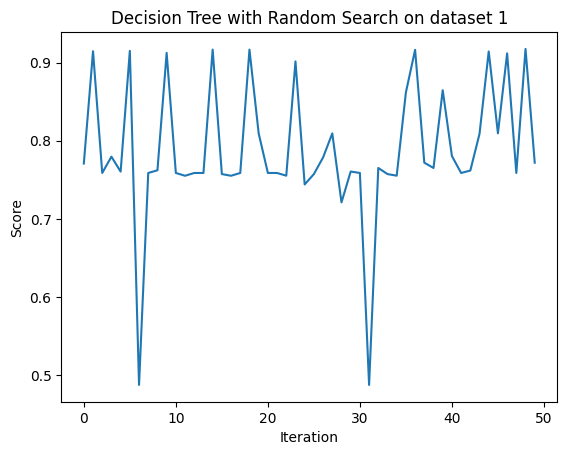

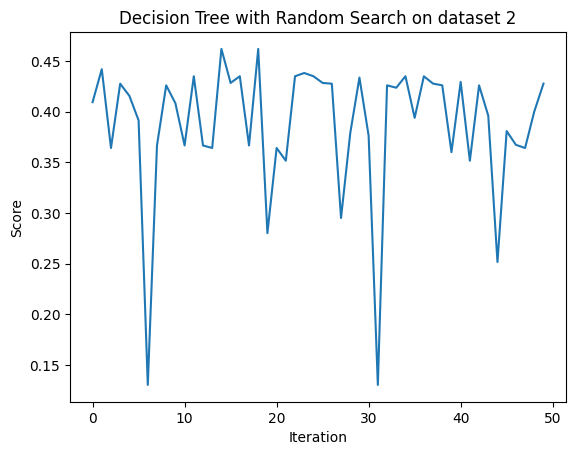

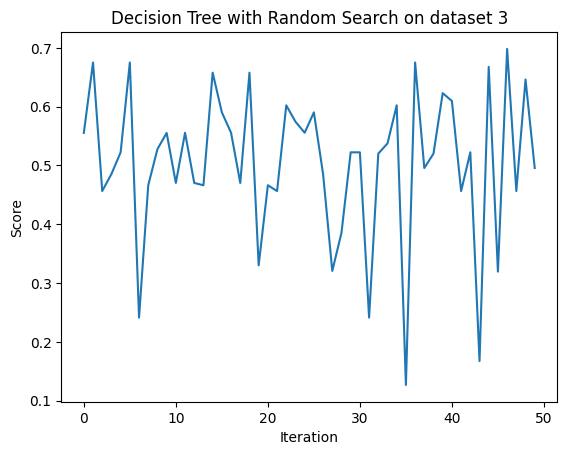

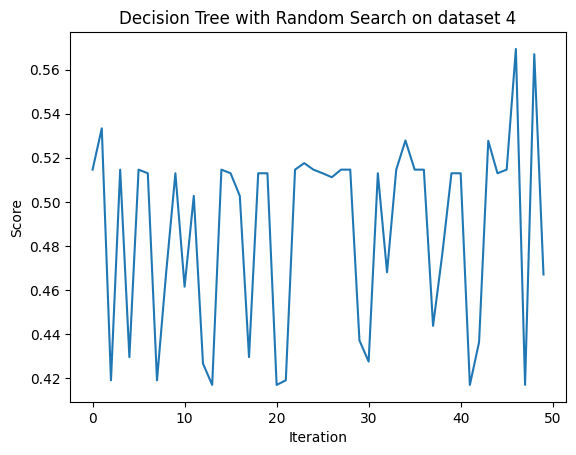

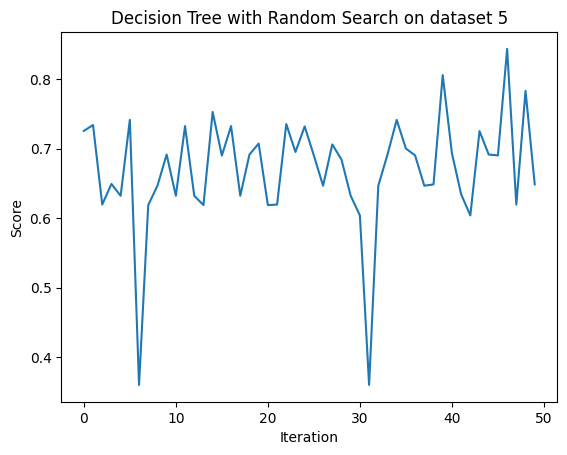

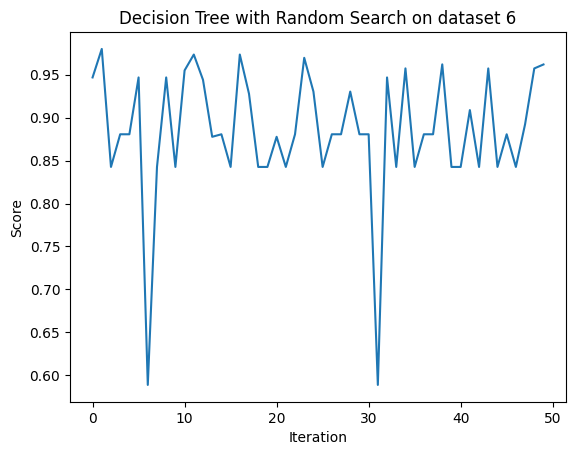

In [14]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Decision Tree with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [15]:
# find d^j
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_decision_tree_configs_for_each_dataset,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/random_search_tunability.csv",
)

d^j: -0.01647409539111544
d^j: 0.0
d^j: -0.06169333525271048
d^j: -0.05246657885573014
d^j: -0.0023862355493354803
d^j: -0.060267395935188595
d^j: -0.022763875680521517


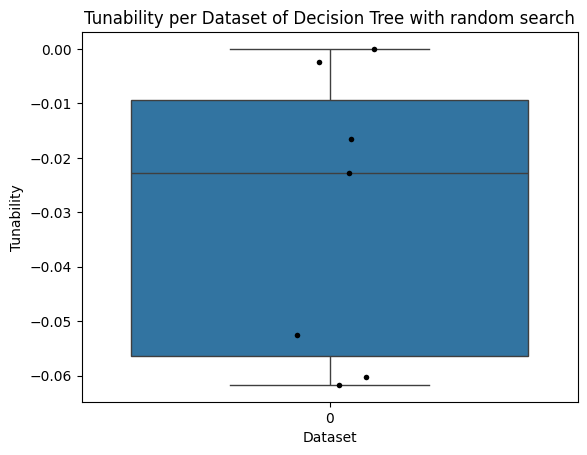

In [16]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with random search")

# show the plot
plt.show()

In [17]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.03086450238065738


## Find best hyperparameters for given dataset with bayesian search

In [18]:
def get_bayes_search_space_decision_tree():
    return (
        {
            "model__ccp_alpha": Real(0.0, 1.0),
            "model__max_depth": Integer(1, 30),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 60),
        },
        NUM_ITER_BAYES,
    )

In [19]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_decision_tree,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_decision_tree(),
    pipeline=get_decision_tree_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/decision_tree/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = 0.8618046493363021
Iteration 2: Score = 0.7765091670213871
Iteration 3: Score = -0.05320919309927987
Iteration 4: Score = 0.6166370611377376
Iteration 5: Score = 0.7781497879594955
Iteration 6: Score = 0.7913990245351916
Iteration 7: Score = 0.6258598490743615
Iteration 8: Score = 0.8608785161210595
Iteration 9: Score = 0.893366277749194
Iteration 10: Score = 0.872978396636084
Iteration 11: Score = 0.6938644238320535
Iteration 12: Score = 0.6938644238320535
Iteration 13: Score = 0.6938644238320535
Iteration 14: Score = 0.6938644238320535
Iteration 15: Score = 0.891050557131708
Iteration 16: Score = 0.7819467475731763
Iteration 17: Score = 0.7772948803981256
Iteration 18: Score = 0.9270584154741359
Iteration 19: Score = 0.7865466239620986
Iteration 20: Score = -0.05320919309927987
Iteration 21: Score = 0.9080386628214614
Iteration 22: Score = 0.7819467475731763
Iteration 23: Score = 0.7819467475731763
Iteration 24: Score = 0.9656080322153728
Iteration 25: Score = 0.

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = 0.7487772833917775
Iteration 2: Score = 0.7464422552709598
Iteration 3: Score = 0.7327128428176481
Iteration 4: Score = 0.8309223467703186
Iteration 5: Score = 0.7461069715960962
Iteration 6: Score = 0.778924694394618
Iteration 7: Score = 0.8447334929885788
Iteration 8: Score = 0.7748790305328666
Iteration 9: Score = 0.7792890928738874
Iteration 10: Score = 0.7672477800471478
Iteration 11: Score = 0.8104132638705857
Iteration 12: Score = 0.8585182673762889
Iteration 13: Score = 0.859424018449617
Iteration 14: Score = 0.8098445652400409
Iteration 15: Score = 0.8618318499672666
Iteration 16: Score = 0.7827464196022115
Iteration 17: Score = 0.9084773393530259
Iteration 18: Score = 0.9161548868299537
Iteration 19: Score = 0.38802596751508817
Iteration 20: Score = 0.7561747417272262
Iteration 21: Score = 0.8894510232803874
Iteration 22: Score = 0.9201884415795833
Iteration 23: Score = 0.6843672010227231
Iteration 24: Score = 0.9292107170429749
Iteration 25: Score = 0.93

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.3607411589080864
Iteration 2: Score = 0.3705058565591358
Iteration 3: Score = 0.43902437961315827
Iteration 4: Score = 0.4383480786937529
Iteration 5: Score = 0.33434868221557956
Iteration 6: Score = 0.35964245675382644
Iteration 7: Score = 0.34016305949982667
Iteration 8: Score = 0.3182299904563064
Iteration 9: Score = 0.35835357406937485
Iteration 10: Score = 0.2978611874828253
Iteration 11: Score = 0.44238877864335907
Iteration 12: Score = 0.42843100406666956
Iteration 13: Score = 0.40241101484342695
Iteration 14: Score = 0.4203466124591938
Iteration 15: Score = 0.4105978416260657
Iteration 16: Score = 0.37470194749935004
Iteration 17: Score = 0.3426622374103614
Iteration 18: Score = 0.4167255886006001
Iteration 19: Score = 0.43703197742220434
Iteration 20: Score = 0.3403321008165838
Iteration 21: Score = 0.452479521979121
Iteration 22: Score = 0.4677145773437624
Iteration 23: Score = 0.41711612685828303
Iteration 24: Score = 0.4364572147412148
Iteration 25: S

### Plot bayes optimization history for each dataset

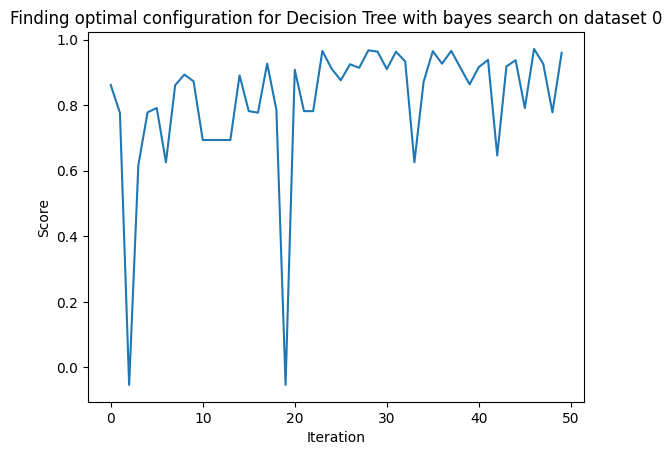

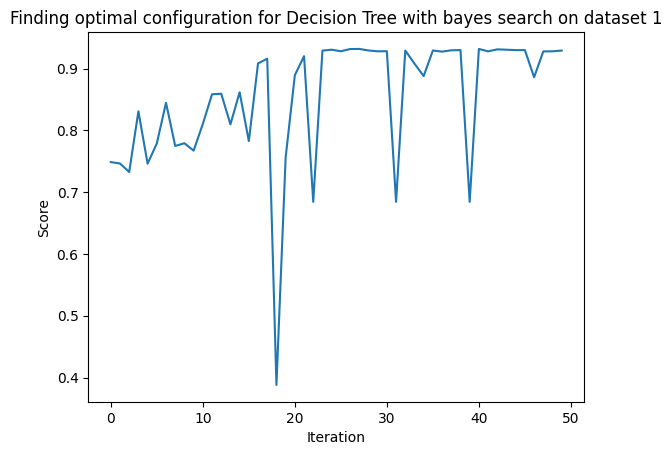

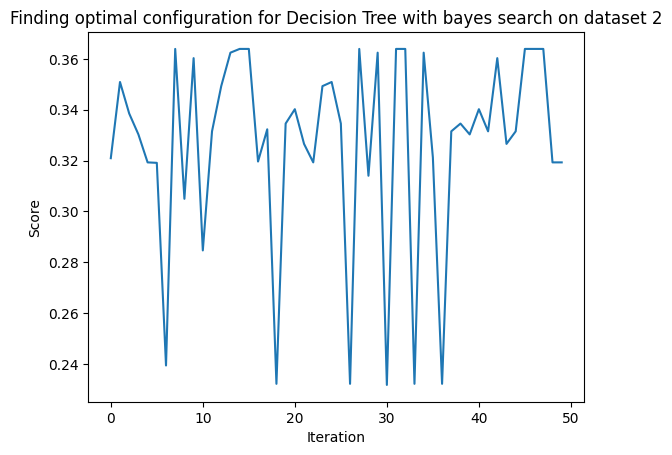

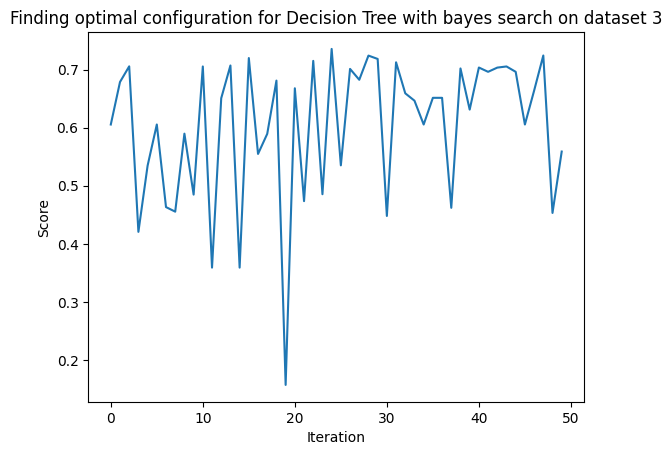

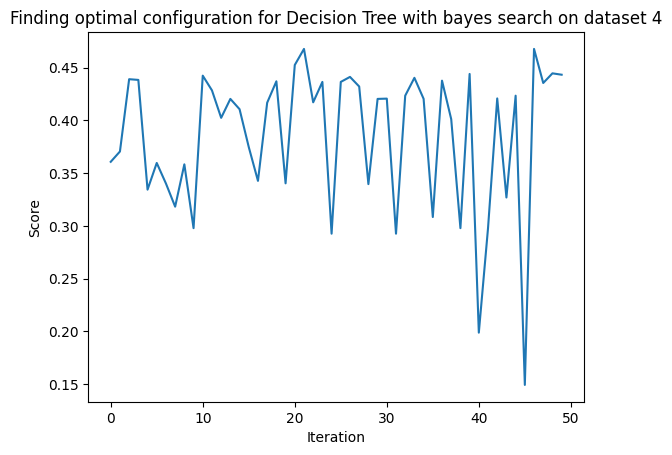

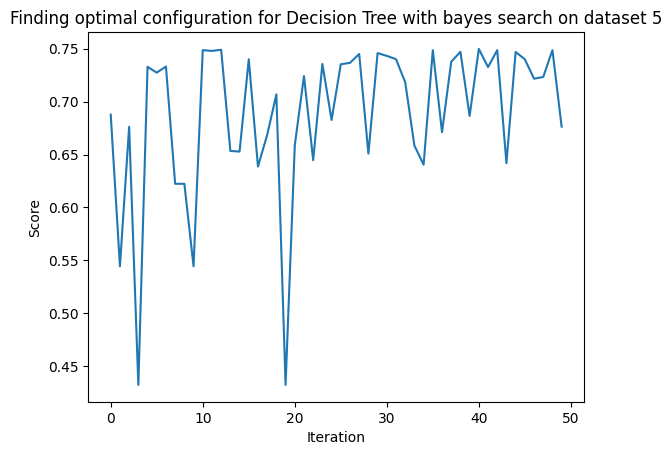

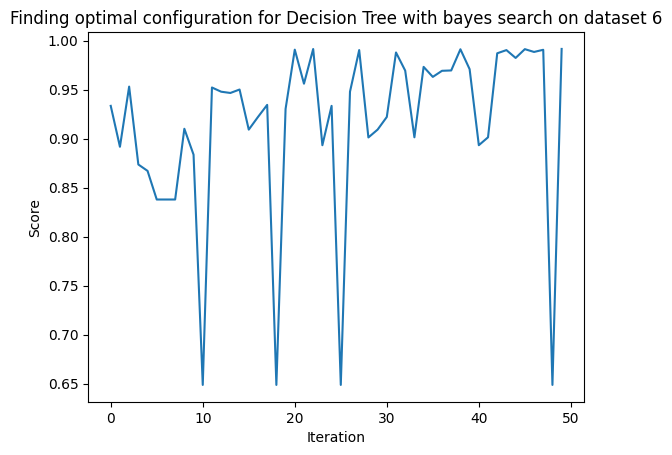

In [20]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Decision Tree with bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [21]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_decision_tree,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/bayes_tunability.csv",
)

d^j: 0.001011271936315672
d^j: -0.024549966963031356
d^j: 0.03349353735343508
d^j: 0.040283743921068926
d^j: 0.04431557410510323
d^j: 0.035685527028508024
d^j: -0.027616344389975178


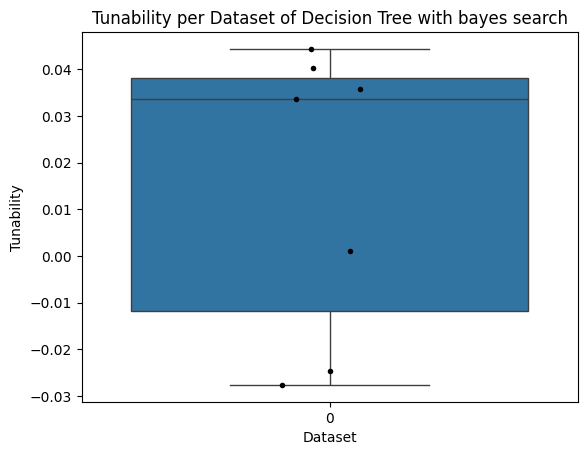

In [22]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with bayes search")

# show the plot
plt.show()

In [23]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.014660477570203485


# 2. ElasticNet

## Prepare model and search space

In [24]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [25]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(SEED)
    alpha = [2**i for i in range(-10, 11, 1)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_ELASTIC_NET
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

## Find optimal default hyperparameters 

In [28]:
# find teta*

(
    optimal_config_elasticnet,
    best_summary_score_elasticnet,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_elasticnet_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/elasticnet/optimal_config_search_history.csv"
)

0
1


2
3
4
5


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.860e+11, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.793e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.976e+10, tolerance: 5.962e+06 Linear reg

39
40
41
42
43
44
45
46
47
48
49


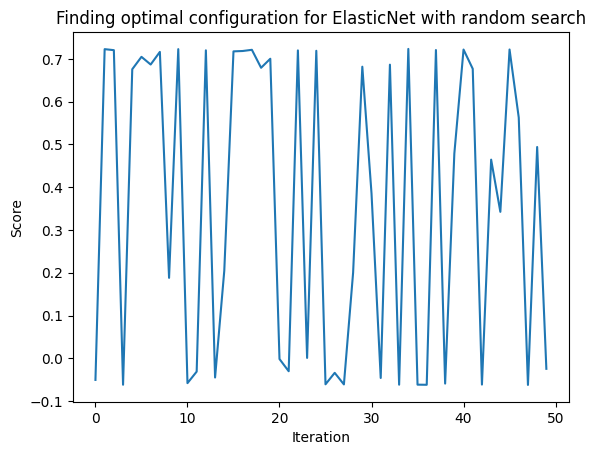

In [29]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for ElasticNet with random search")
plt.show()

In [30]:
print(optimal_config_elasticnet)
print(best_summary_score_elasticnet)

{'model__alpha': 0.0009765625, 'model__l1_ratio': 0.15000000000000002}
0.723080523481589


## Evaluate model with optimal hyperparameters on each dataset

In [31]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_elasticnet_pipeline()
    optimal_model.set_params(**optimal_config_elasticnet)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal elasticnet score on dataset : " + str(score))

Optimal elasticnet score on dataset : 0.9498813839291849
Optimal elasticnet score on dataset : 0.9232679918840747
Optimal elasticnet score on dataset : 0.4566286471067492
Optimal elasticnet score on dataset : 0.5445476360592428
Optimal elasticnet score on dataset : 0.5581866568920202
Optimal elasticnet score on dataset : 0.6373165272340349
Optimal elasticnet score on dataset : 0.9917348212658172


## Find best hyperparameters for given dataset with random search

In [32]:
# find tate^(j)*
(
    best_elasticnet_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_elasticnet_pipeline(),
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/elasticnet/random_search_iteration_scores_dataset_{i}.csv",
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.793e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 0
score: 0.9504290627927017
best config: {'model__alpha': 0.0078125, 'model__l1_ratio': 0.8}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.976e+10, tolerance: 5.962e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

dataset: 1
score: 0.9239271647899755
best config: {'model__alpha': 0.03125, 'model__l1_ratio': 1.0}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+06, tolerance: 2.145e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 2
score: 0.4608813604104236
best config: {'model__alpha': 0.03125, 'model__l1_ratio': 0.7000000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.860e+11, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+13, tolerance: 4.005e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

dataset: 3
score: 0.5538581133434504
best config: {'model__alpha': 0.00390625, 'model__l1_ratio': 0.5}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+03, tolerance: 3.145e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 4
score: 0.5636432956877125
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.8}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e+04, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 5
score: 0.6524487643894683
best config: {'model__alpha': 0.0078125, 'model__l1_ratio': 0.4}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.750e+03, tolerance: 9.548e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 6
score: 0.9926934600160636
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.8}


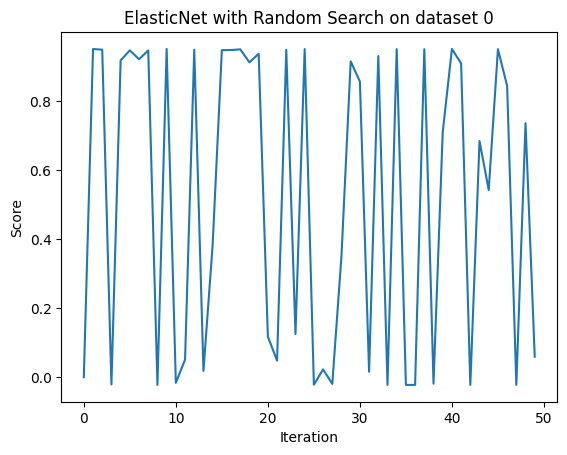

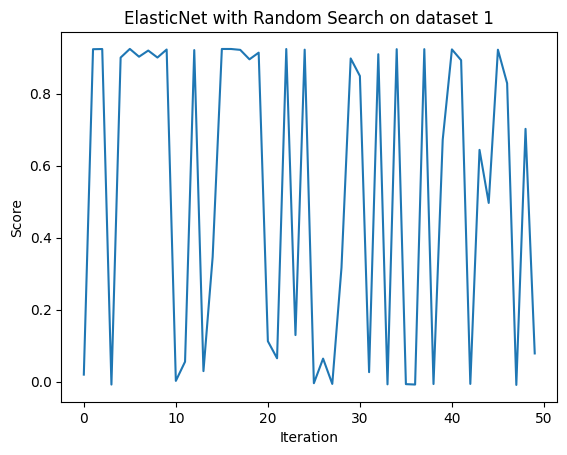

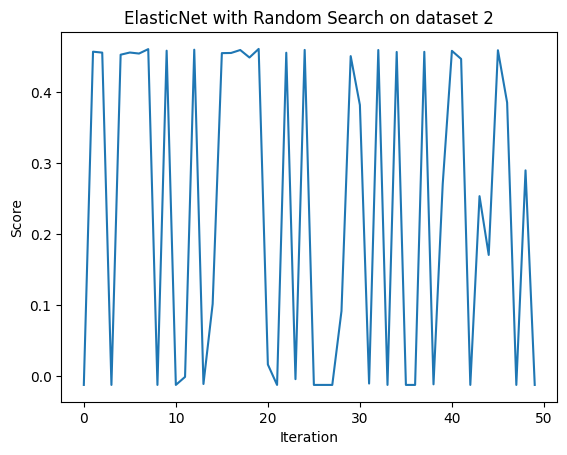

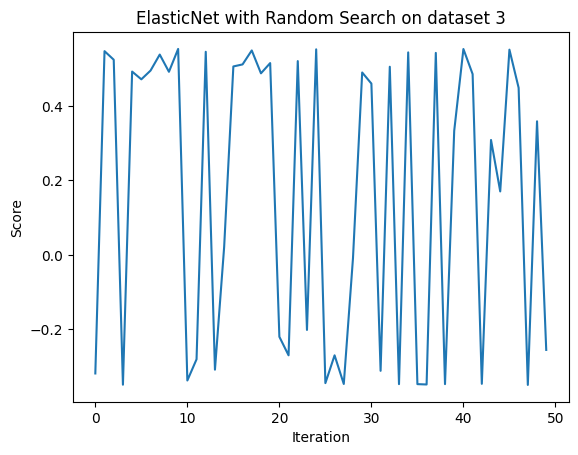

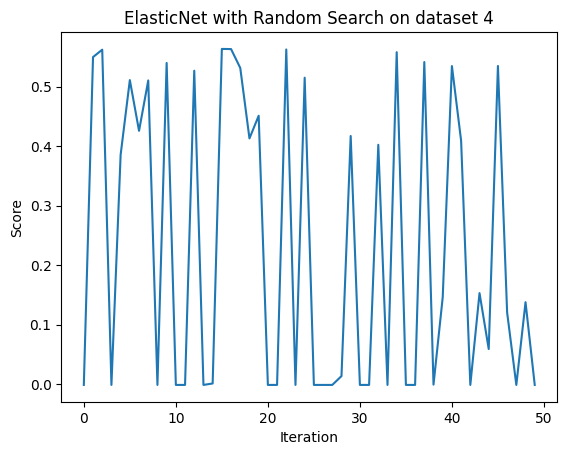

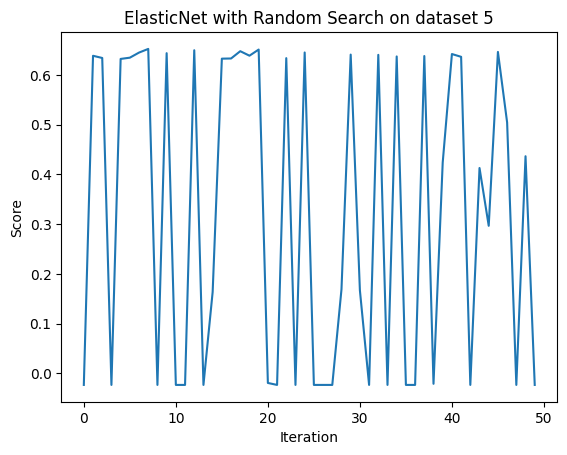

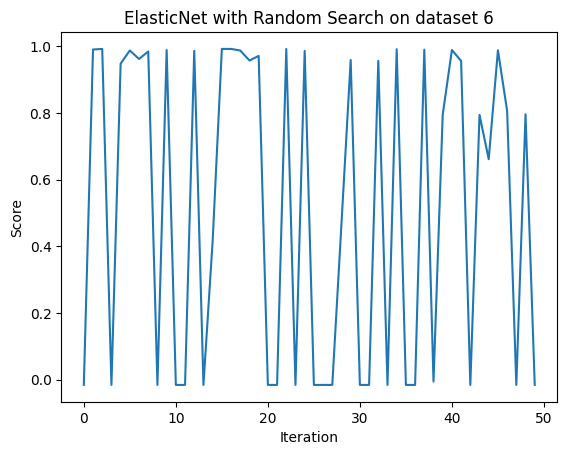

In [33]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"ElasticNet with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [34]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_elasticnet_configs_for_each_dataset,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/random_search_tunability.csv",
)

d^j: -0.0005476788635168095


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(


d^j: -0.0006591729059007845
d^j: -0.0042527133036743825
d^j: -0.00931047728420753
d^j: -0.005456638795692359
d^j: -0.015132237155433437
d^j: -0.0009586387502463767


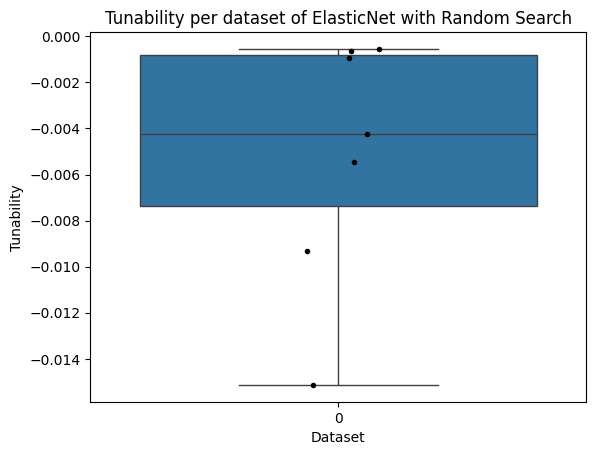

In [35]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of ElasticNet with Random Search")

# show the plot
plt.show()

In [36]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.005188222436953097


## Find best hyperparameters for given dataset with bayesian search


In [37]:
def get_bayes_search_space_elasticnet():
    return (
        {
            "model__alpha": Real(0.0, 1.0),
            "model__l1_ratio": Real(0.0, 1.0),
        },
        NUM_ITER_BAYES,
    )

In [38]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
best_configs_for_elasticnet, histories = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_elasticnet(),
    pipeline=get_elasticnet_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/elasticnet/bayes_iteration_scores_dataset_{i}.csv"
    )

Iteration 1: Score = 0.8787027514798653
Iteration 2: Score = 0.570379942954186
Iteration 3: Score = 0.34822422981358314
Iteration 4: Score = 0.6120732867047118
Iteration 5: Score = 0.7087473023677795
Iteration 6: Score = 0.7018495251773617
Iteration 7: Score = 0.7635458525849668
Iteration 8: Score = 0.8092234222199046
Iteration 9: Score = 0.4828231696137403
Iteration 10: Score = 0.5847868048599267
Iteration 11: Score = 0.9120659858635356
Iteration 12: Score = 0.9050352070645037
Iteration 13: Score = 0.9122049781651098
Iteration 14: Score = 0.9050352070645037
Iteration 15: Score = 0.9112710109586629
Iteration 16: Score = 0.9108444949479131
Iteration 17: Score = 0.9050352070645037
Iteration 18: Score = 0.9116526613098808
Iteration 19: Score = 0.9121389806686067
Iteration 20: Score = 0.9050352070645037
Iteration 21: Score = 0.9050352070645037
Iteration 22: Score = 0.9102149377379682
Iteration 23: Score = 0.9102351677969918
Iteration 24: Score = 0.9088959256464874
Iteration 25: Score = 0.9

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.022563309834511602
Iteration 2: Score = -0.0367905738010194
Iteration 3: Score = 0.4556487609589426
Iteration 4: Score = -0.019141996912752625
Iteration 5: Score = -0.04783734841928187
Iteration 6: Score = -0.04783734841928187
Iteration 7: Score = -0.04783734841928187
Iteration 8: Score = 0.001670671783990274
Iteration 9: Score = 0.20397565098460854
Iteration 10: Score = 0.062283620466451216
Iteration 11: Score = 0.5143896052187129
Iteration 12: Score = 0.5143896052187129
Iteration 13: Score = 0.5143896052187129
Iteration 14: Score = 0.43937940969450595
Iteration 15: Score = 0.3611546642095842
Iteration 16: Score = 0.5143896052187129
Iteration 17: Score = -0.04783734841928187
Iteration 18: Score = 0.14154311313973805
Iteration 19: Score = 0.5143896052187129
Iteration 20: Score = 0.5143896052187129
Iteration 21: Score = 0.5143896052187129
Iteration 22: Score = -0.04783734841928187
Iteration 23: Score = 0.5143896052187129
Iteration 24: Score = 0.5143896052187129
I

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = 0.991170134127756
Iteration 2: Score = 0.9105726816851455
Iteration 3: Score = 0.28765171451983174
Iteration 4: Score = 0.7822669703214055
Iteration 5: Score = 0.5956626226477446
Iteration 6: Score = 0.7996099539389177
Iteration 7: Score = 0.5706114554875898
Iteration 8: Score = 0.47131109129010584
Iteration 9: Score = 0.621339261086474
Iteration 10: Score = 0.780610497461727
Iteration 11: Score = 0.9952304205703946
Iteration 12: Score = 0.9952304205703946
Iteration 13: Score = 0.9952304205703946
Iteration 14: Score = 0.9157706879831105
Iteration 15: Score = 0.9952304205703946
Iteration 16: Score = 0.621920832161071
Iteration 17: Score = 0.950551828875254
Iteration 18: Score = 0.9952304205703946
Iteration 19: Score = 0.8747735689958466
Iteration 20: Score = 0.9952304205703946
Iteration 21: Score = 0.8629603114999528
Iteration 22: Score = 0.9870029000981786
Iteration 23: Score = 0.9952304205703946
Iteration 24: Score = 0.987065421367479
Iteration 25: Score = 0.99523

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e+01, tolerance: 9.548e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### Plot bayes optimization history for each dataset

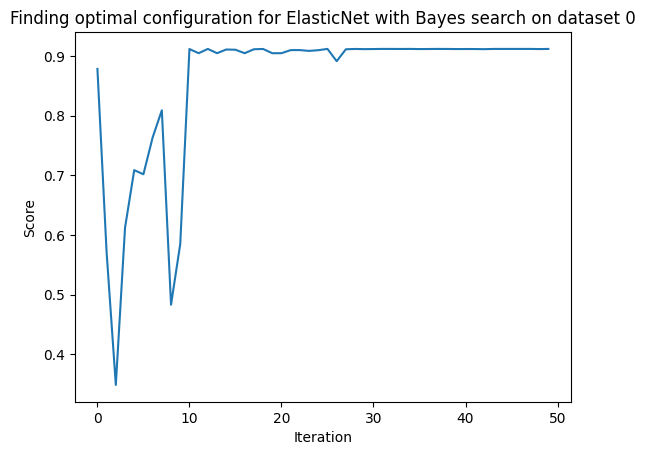

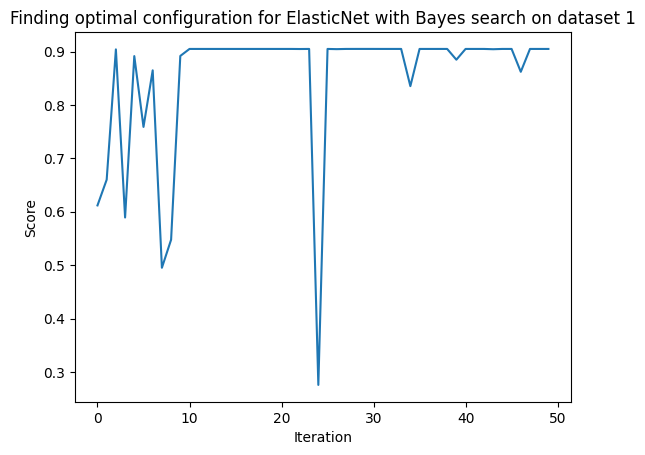

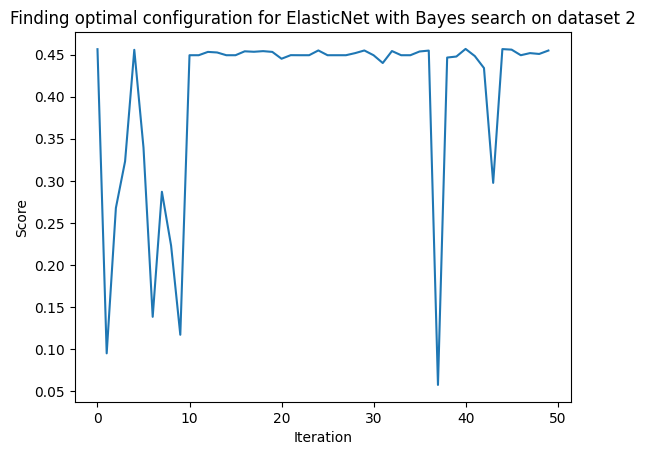

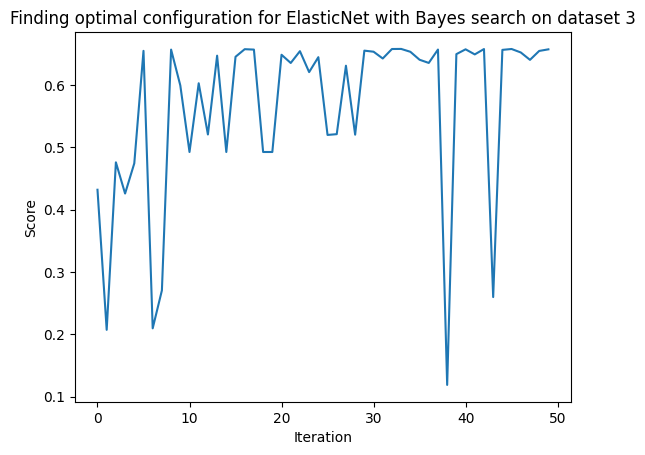

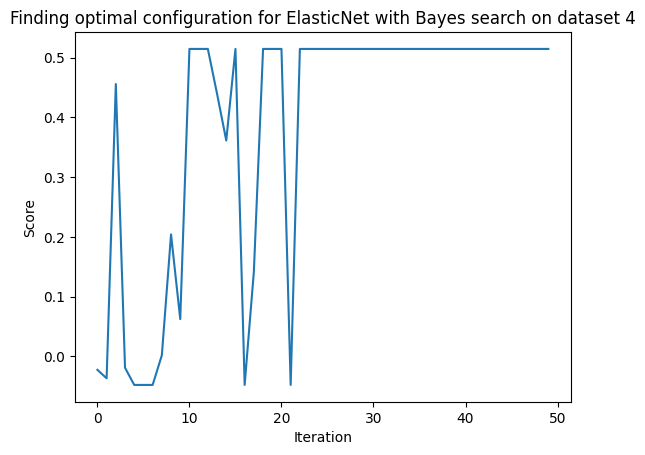

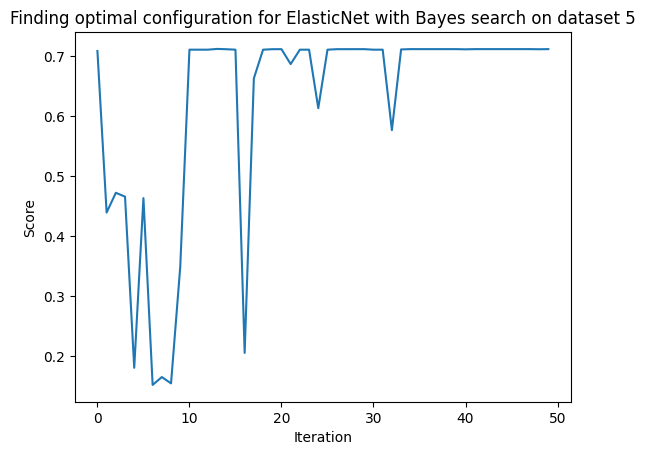

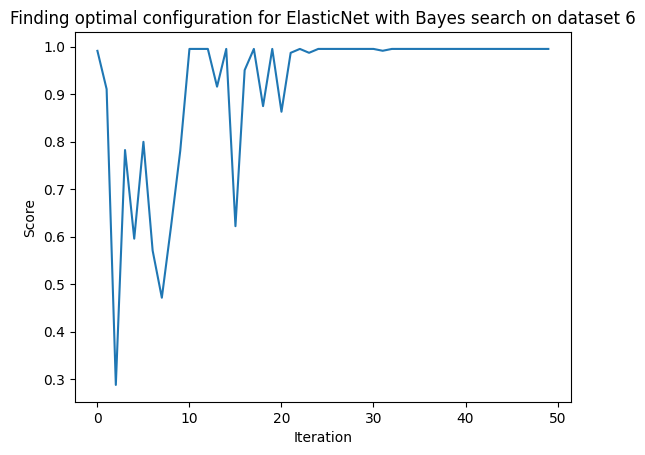

In [39]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for ElasticNet with Bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [40]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_elasticnet,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/bayes_tunability.csv",
)

d^j: 0.0025147385302798364
d^j: -0.00025113853075564574
d^j: -0.006895860308848256
d^j: 0.06040066046548431
d^j: -0.006779572470282935
d^j: -0.00024168799028267962


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.408e+02, tolerance: 3.145e-01 L

d^j: -0.0011569686711079274


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e+01, tolerance: 9.548e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


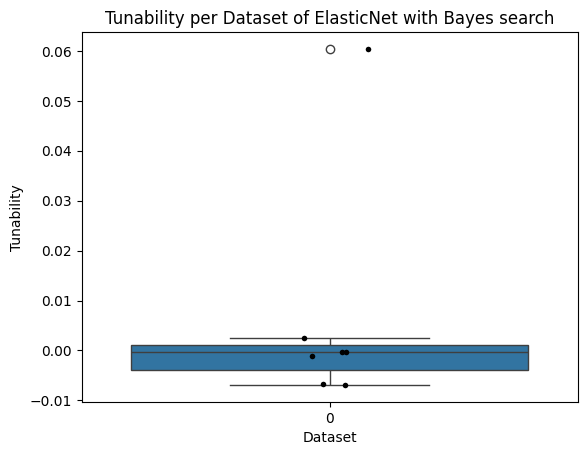

In [41]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of ElasticNet with Bayes search")

# show the plot
plt.show()

In [42]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.006798595860640958


# 3. Random Forest

## Prepare model and search space

In [43]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor(bootstrap=True)
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [44]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(SEED)
    # max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 528,5)
    min_samples_leaf_values = range(1, 10, 1)
    n_estimators_values = range(1, 2000, 10)
    max_samples_values = [float(i) * 0.1 for i in range(1, 11, 1)]
    max_features_values = [i for i in range(1, 15, 1)]
    all_combinations = list(
        itertools.product(
            # max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
            max_samples_values,
            max_features_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_RANDOM_FOREST
    )
    parameter_names = [
        # "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
        "model__max_samples",
        "model__max_features",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

## Find optimal default hyperparameters 

In [45]:
(
    optimal_config_random_forest,
    best_summary_score_random_forest,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_random_forest_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/random_forest/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


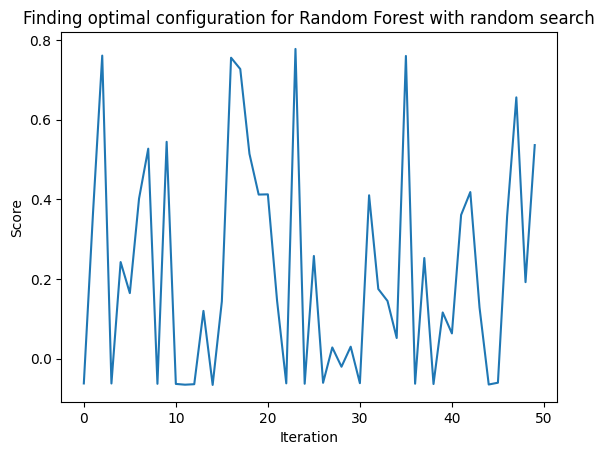

In [46]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Random Forest with random search")
plt.show()

In [47]:
print(optimal_config_random_forest)
print(best_summary_score_random_forest)

{'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
0.777482595726086


## Evaluate model with optimal hyperparameters on each dataset

In [48]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_random_forest_pipeline()
    optimal_model.set_params(**optimal_config_random_forest)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal random_forest score on dataset : " + str(score))

Optimal random_forest score on dataset : 0.9602149763722608
Optimal random_forest score on dataset : 0.9211871938309688
Optimal random_forest score on dataset : 0.4734542883527647
Optimal random_forest score on dataset : 0.6627333260238264
Optimal random_forest score on dataset : 0.6097769025166107
Optimal random_forest score on dataset : 0.8309117590612851
Optimal random_forest score on dataset : 0.9902476933864949


## Find best hyperparameters for given dataset with random search

In [49]:
# find tate^(j)*
(
    best_random_forest_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_random_forest_pipeline(),
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/random_forest/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9601007142272948
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 1
score: 0.9190784460940951
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 2
score: 0.4843823543855986
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 3, 'model__n_estimators': 1941, 'model__max_samples': 0.5, 'model__max_features': 6}
dataset: 3
score: 0.6562814637317145
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 4
score: 0.6075078017041036
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 5
score: 0.8

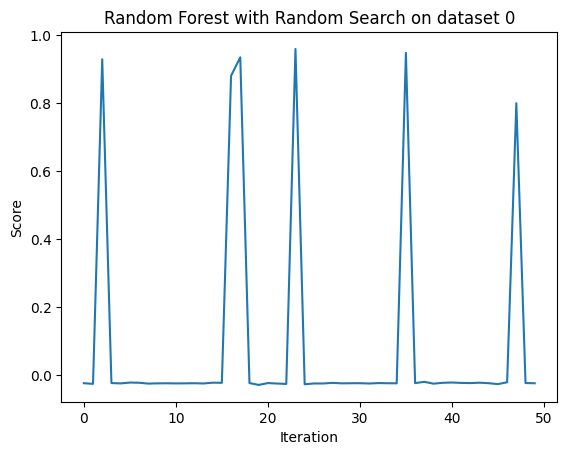

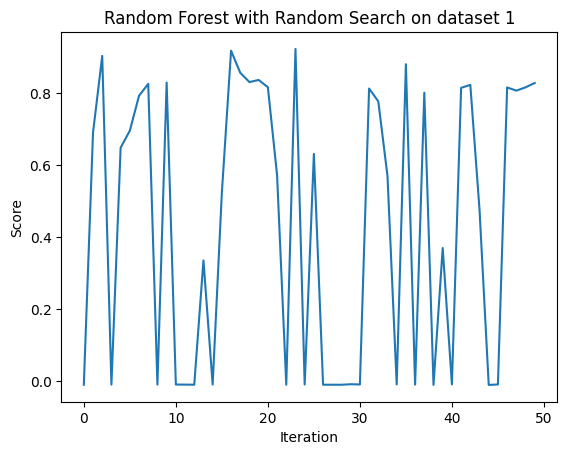

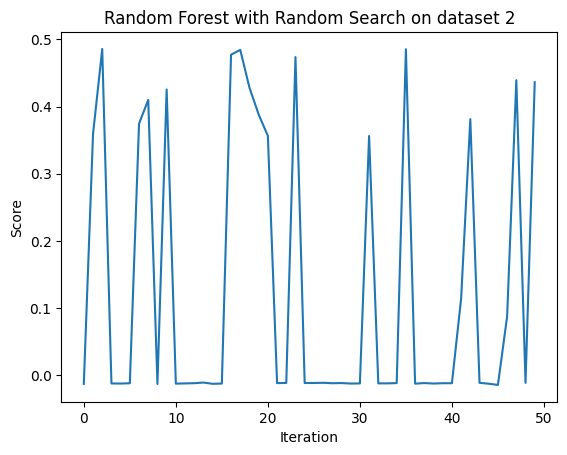

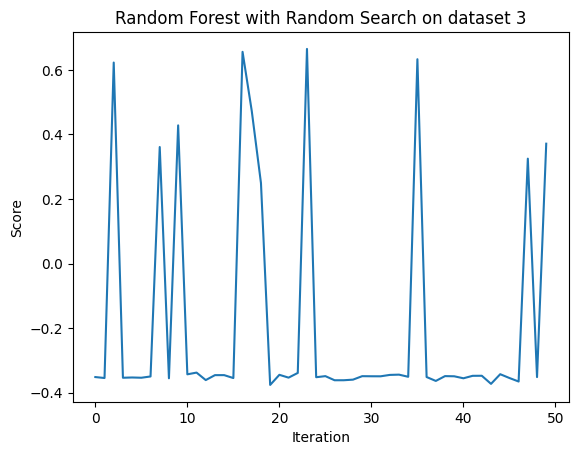

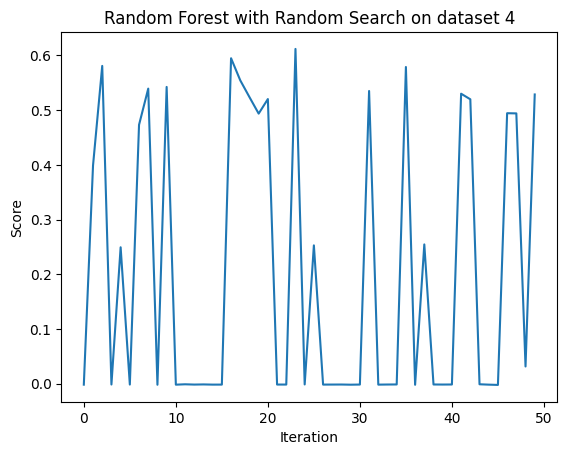

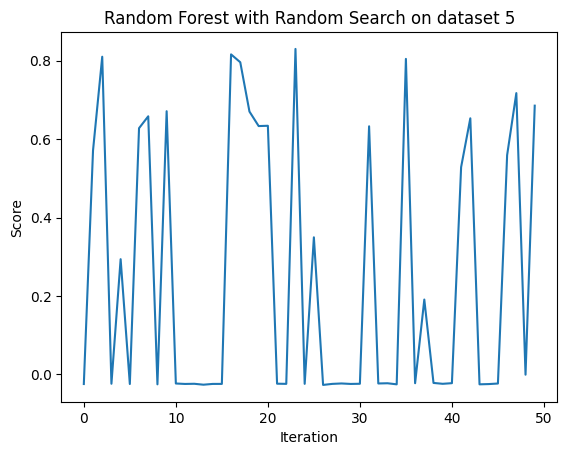

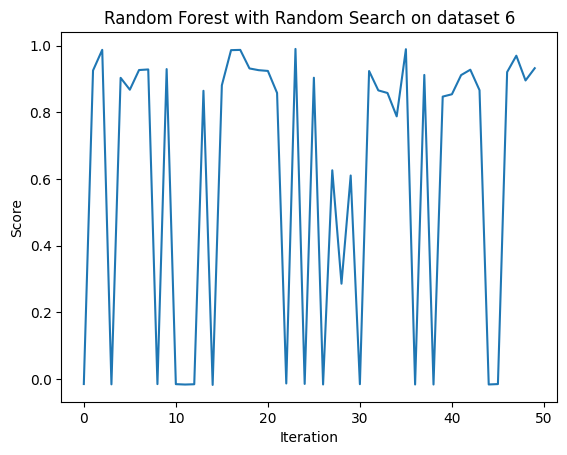

In [50]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Random Forest with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [51]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_random_forest_configs_for_each_dataset,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/random_search_tunability.csv",
)

d^j: -0.00046707386057087685
d^j: -0.001416217583152135
d^j: -0.00948111941161156
d^j: 0.0025169604578653137
d^j: -0.00028674826508767737
d^j: 0.0014283146257489943
d^j: 0.00012769382073340996


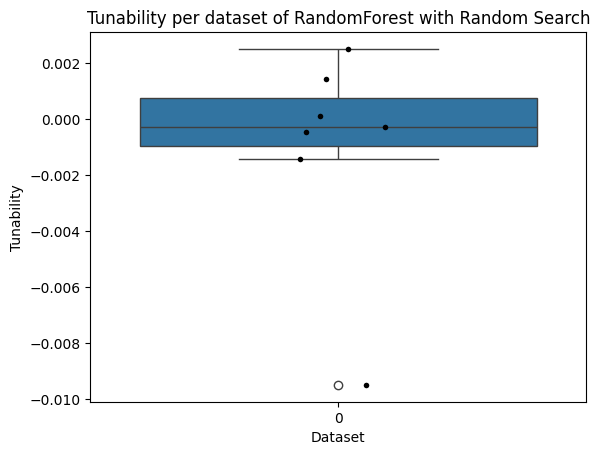

In [52]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of RandomForest with Random Search")

# show the plot
plt.show()

In [53]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.0010825986022963616


## Find best hyperparameters for given dataset with bayesian search


In [54]:
def get_bayes_search_space_random_forest():
    return (
        {
            "model__min_samples_split": Integer(2, 528),
            "model__min_samples_leaf": Integer(2, 10),
            "model__min_samples_leaf": Integer(1, 60),
            "model__n_estimators": Integer(1, 2000),
            "model__max_samples_values": Real(0.1, 1.0),
            "model__max_features_values": Integer(1, 14),
        },
        NUM_ITER_BAYES,
    )

In [55]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_random_forest,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_random_forest(),
    pipeline=get_random_forest_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/random_forest/bayes_iteration_scores_dataset_{i}.csv"
    )

ValueError: Invalid parameter 'max_features_values' for estimator RandomForestRegressor(). Valid parameters are: ['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

### Plot bayes optimization history for each dataset

In [ ]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Random Forest with Bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [ ]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_random_forest,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/bayes_tunability.csv",
)

In [ ]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Random Forest with Bayes search")

# show the plot
plt.show()

In [ ]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)